In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [11]:
df = pd.read_csv('customer_segmentation.csv', encoding='latin1')

In [12]:
df.shape
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [13]:
df = df.dropna(subset=['CustomerID', 'InvoiceNo'])

In [14]:
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

In [15]:
df = df[df['Quantity'] > 0]

In [16]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [17]:
df['InvoiceDate'].dtype

dtype('<M8[ns]')

In [18]:
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']

In [19]:
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

In [20]:
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalAmount': 'sum'
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

rfm.head()


,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


In [21]:
rfm['R_Score'] = pd.qcut(rfm['Recency'], 4, labels=[4,3,2,1])

In [22]:
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1,2,3,4])

In [23]:
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 4, labels=[1,2,3,4])

In [25]:
rfm[['R_Score','F_Score','M_Score']] = rfm[['R_Score','F_Score','M_Score']].astype(int)

In [28]:
rfm['R_Score'].value_counts()

,count
R_Score,
4,1126
1,1084
2,1066
3,1063


In [29]:
rfm['F_Score'].value_counts()

,count
F_Score,
1,1085
4,1085
2,1085
3,1084


In [30]:
rfm['M_Score'].value_counts()

,count
M_Score,
4,1085
2,1085
1,1085
3,1084


In [32]:
rfm['RFM_Score'] = (
    rfm['R_Score'].astype(str) +
    rfm['F_Score'].astype(str) +
    rfm['M_Score'].astype(str)
)

In [33]:
rfm['RFM_Score'].value_counts()

,count
RFM_Score,
444,489
111,302
344,213
121,187
112,171
...,...
413,3
441,3
314,2


In [34]:
def segment_customer(row):
    if row['R_Score'] == 4 and row['F_Score'] == 4:
        return 'Champions'
    elif row['F_Score'] >= 3 and row['M_Score'] >= 3:
        return 'Loyal Customers'
    elif row['R_Score'] >= 3 and row['F_Score'] <= 2:
        return 'Potential Loyalist'
    elif row['R_Score'] <= 2 and row['F_Score'] >= 3:
        return 'At Risk'
    else:
        return 'Others'

rfm['Segment'] = rfm.apply(segment_customer, axis=1)

rfm.head()


,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment
0,12346.0,326,1,77183.60,1,1,4,114,Others
1,12347.0,2,7,4310.00,4,4,4,444,Champions
2,12348.0,75,4,1797.24,2,3,4,234,Loyal Customers
3,12349.0,19,1,1757.55,3,1,4,314,Potential Loyalist
4,12350.0,310,1,334.40,1,1,2,112,Others


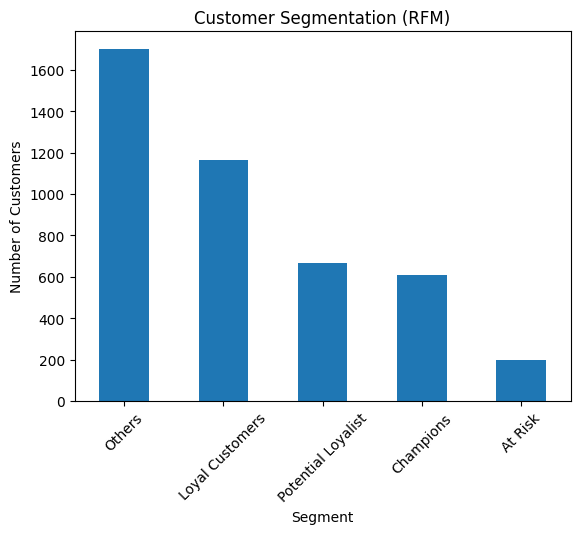

In [35]:
segment_counts = rfm['Segment'].value_counts()

plt.figure()
segment_counts.plot(kind='bar')
plt.title("Customer Segmentation (RFM)")
plt.xlabel("Segment")
plt.ylabel("Number of Customers")
plt.xticks(rotation=45)
plt.show()


In [37]:
rfm.to_csv('rfm_segments.csv', index=False)